### Outline
- **建立模型**: 介紹 pytorch 中建立模型的方式。
- **Linear Polynomial (一元一次多項式)**: 以簡單的 NN 建立線性迴歸模型。
- **Linear Polynomial (二元一次多項式)**: 以兩個 input 的 NN 來建立二元一次的線性迴歸模型。
- **動手試試看 (三元一次多項式)**: 以三個 input 的 NN 建立三元一次的線性迴歸模型。

## PyTorch 基本介紹

PyTorch 是目前最受歡迎的深度學習框架之一，由 Meta AI（前 Facebook AI Research）於 2017 年開源。它的設計理念比較像是一個「隨寫隨執行」的工具。你寫到哪裡，它就馬上幫你算到哪裡，不需要事先畫好整張運算流程圖，像是隨時在筆記本上即時做計算。這樣一來，你用一般的程式邏輯（像是 for 迴圈或 if 判斷）寫程式的方式不必改變，程式出錯時也更容易找出問題。此外，PyTorch 內建了自動幫你算導數的機制，就像幫你自動做微分運算，搭配它現成的模型模組和各種調整計算速度的工具，以及方便讀取整理資料的功能，讓你從寫原型到正式訓練模型，都能快速上手、少走彎路。

| 名稱                          | 說明                                                                                                                                                 |
|-------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|
| 張量 (Tensor)                 | 多維陣列結構，類似 NumPy ndarray，但可利用 GPU 加速運算。                                                                                              |
| 設備管理 (Device)             | 用於指定運算裝置（CPU 或 CUDA GPU），並可透過 `.to(device)` 方法在裝置間搬移張量與模型。                                                               |
| NumPy 互轉                    | 張量與 NumPy 陣列可相互轉換，便於與現有科學計算生態整合。`torch.from_numpy(ndarray)`與`Tensor.numpy()`                                    |
| Autograd（自動求導）          | 自動微分引擎，透過在張量上設定 `requires_grad=True` 即可追蹤梯度，並在呼叫 `backward()` 時自動計算並累積梯度。                                         |
| Dataset（資料集）             | 繼承並實作 `__len__()` 與 `__getitem__()` 的類別，用以統一資料讀取介面，支援自訂與內建資料集。                                                           |
| DataLoader（資料載入器）       | 負責批次化資料、隨機洗牌、並行讀取等功能，常與 Dataset 配合使用以簡化訓練流程。                                                                        |
| Data Generator                | 可邊讀邊產生資料，動態生成樣本或批次，適合大型資料或即時資料擴增場景。                                     |
| 模型定義 (`nn.Module`)        | 所有神經網路模型皆繼承自 `torch.nn.Module`，在 `__init__()` 定義層結構，並於 `forward()` 中實作前向傳播。                                              |
| 損失函數 (Loss Function)      | 衡量模型預測與真實標籤差距的函數，常見如交叉熵（CrossEntropyLoss）、均方誤差（MSELoss）等。                                                             |
| 優化器 (Optimizer)            | 根據計算出的梯度更新模型參數，常見如 SGD、Adam 等，皆位於 `torch.optim` 模組。                                                                         |
| 訓練迴圈 (Training Loop)      | 一個 epoch 中遍歷所有批次：前向傳播 → 計算損失 → 反向傳播 → 參數更新，用以逐步優化模型。                                                               |
| Save & Load Model – state_dict | 儲存模型權重：`torch.save(model.state_dict(), path)`；載入時先建立相同結構模型，再用 `model.load_state_dict(torch.load(path))` 恢復參數。                   |
| Save & Load Model – 完整模型   | 儲存完整模型：`torch.save(model, path)`；載入時直接呼叫 `model = torch.load(path)` 即可。                                                               |

# 載入函數

In [143]:
!pip install torchsummary

In [144]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# torch api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary
from sklearn.metrics import mean_squared_error

In [145]:
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡
device

device(type='cpu')

# 一、如何建立模型

接下來，我們使用 `Pytorch` 來建立模型，並且訓練模型來擬合線性函數 $y=wx+b$

在 Pytorch 中，有兩種建立模型的方式，分別是：

* `Sequential API`
* `Model subclassing`

## 1. Sequential API

Sequential API 的方式是透過 `nn.Sequential` 不斷的往後疊加層數，這種方式對於一些簡單的模型來說非常方便，但是就沒辦法實現比較複雜的模型。

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [146]:
# 建立模型, nn.Linear為全連接層
model_1 = nn.Sequential(nn.Linear(in_features = 1, out_features = 1, bias=True))

# 將模型載入gpu中
model_1 = model_1.to(device)

# 查看模型的架構
summary(model_1, input_size = (1, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [147]:
model_1

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [148]:
# 觀察參數，要先查看模型架構的名稱再來使用.weight查看weight，這裡顯示的是初始權重值
print(model_1[0].weight)
# 觀察參數，要先查看模型架構的名稱再來使用.bias查看bias，這裡顯示的是初始權重值
print(model_1[0].bias)

Parameter containing:
tensor([[0.5136]], requires_grad=True)
Parameter containing:
tensor([-0.1536], requires_grad=True)


## 2. Model subclassing

Model subclassing 雖然看起來很複雜，但是在之後實現一些特別複雜的模型就非常方便，透過 `class` 可以將很多層包在一起，可讀性也會比較好。

使用 Model subclassing 要先進行繼承，因為我們要實現的是全連結層，所以繼承對象的層級是 `nn.Module`。

目前主流的所有模型架構皆使用此方法，也可以將nn.Sequential加入model subclassing中。

```bash
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # 定義初始化參數
        # 模型的layer初始化寫在此處，如：nn.Linear等
        
        
    def forward(self, x):
        # 模型的feed forward過程，模型往前走的過程
        # x為輸入進來的tensor
```

In [149]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc = nn.Linear(in_features = 1, out_features = 1, bias = True)

    def forward(self, x):
        output = self.fc(x)
        return output

In [150]:
model_2 = DNN().to(device)
summary(model_2, input_size = (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [151]:
model_2

DNN(
  (fc): Linear(in_features=1, out_features=1, bias=True)
)

In [152]:
# 由於名稱是fc，所以我們是拉fc來查看weights 與 bias
print(model_2.fc.weight)
print(model_2.fc.bias)

Parameter containing:
tensor([[0.8912]], requires_grad=True)
Parameter containing:
tensor([0.5774], requires_grad=True)


# 二、Linear Polynomial(一元一次多項式)，使用模型來進行一個訓練的流程

使用 numpy 來模擬簡單的線性函數，首先準備資料集

$$
 y = wx + b
$$

## 1. 準備資料集

<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
C:\TEMP\ipykernel_20668\2072964170.py:12: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\epsilon$')


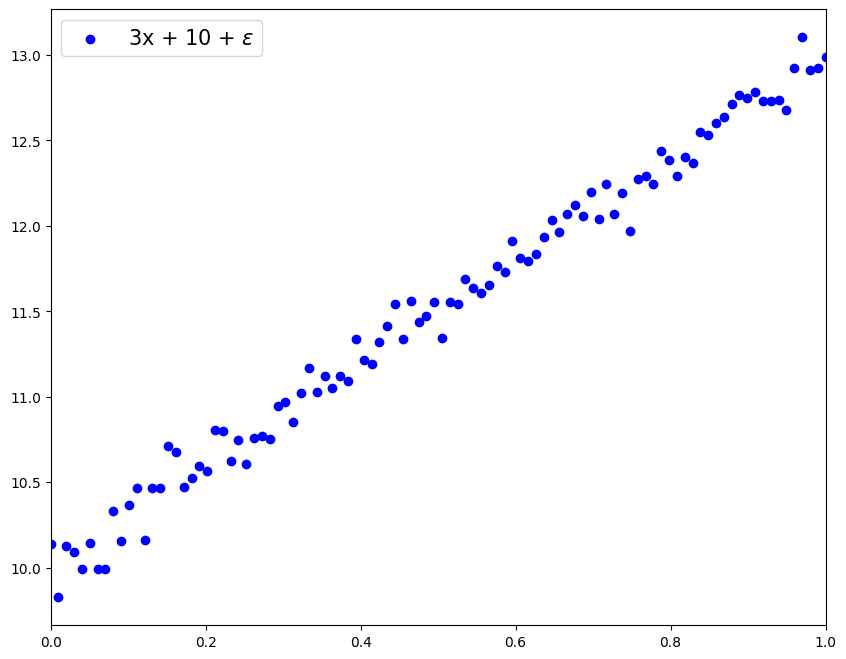

In [153]:
# 準備資料
x_in = np.float32(np.linspace(0, 1, 100))
noise = np.float32(np.random.normal(0, 0.1, size=len(x_in)))

# 設定 W=3, b=10，是模型學習參數的最終目標
y_true = 3 * x_in + 10
# 加上 noise，模擬在真實世界抽樣的結果
y_noise = y_true + noise

# 視覺化資料
plt.figure(figsize=(10, 8))
plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\epsilon$')
plt.axis(xmin=0, xmax=1)
plt.legend(fontsize = 15)
plt.show()

In [154]:
print('x_in_shape:', x_in.shape)
print('y_true_shape:', y_true.shape)
print('y_noise_shape:', y_noise.shape)

x_in_shape: (100,)
y_true_shape: (100,)
y_noise_shape: (100,)


In [155]:
# 包成可供模型訓練的資料型態
Train_list = []

for i in range(len(x_in)):
    Train_list.append([np.array([x_in[i]]), np.array([y_noise[i]])])

## 2. 建立模型

接下來使用 model subclassing 的方式建立模型。

In [156]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc = nn.Linear(in_features = 1, out_features = 1, bias = True)

    def forward(self, x):
        output = self.fc(x)
        return output

model = DNN().to(device)
model

DNN(
  (fc): Linear(in_features=1, out_features=1, bias=True)
)

## 還沒訓練時的預測表現

### 查看模型參數

使用 `.weights` 以及 `.bias` 可以拿取模型所有的參數

In [157]:
print('w_true:', 3, '\nb_true:', 10)
print('-'*10)
print('w_pred:', model.fc.weight.data, '\nb_pred:', model.fc.bias.data)

w_true: 3 
b_true: 10
----------
w_pred: tensor([[-0.2216]]) 
b_pred: tensor([-0.9559])


### 試著先用還沒有訓練過的權重預測結果

模型預測：預測結果 = model(預測的資料)
* 預測的資料維度要為 (batch_size, 輸入資料)
* 預測的資料要轉換成 pytorch tensor 才能進行預測

In [158]:
# 維度從 (100,) -> (100,1)
batch_x_in = np.reshape(x_in, (-1,1))
print('x_in.shape:', x_in.shape)
print('batch_x_in.shape:', batch_x_in.shape)

x_in.shape: (100,)
batch_x_in.shape: (100, 1)


In [159]:
print(x_in)
print(batch_x_in)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151516 0.16161616 0.17171717
 0.18181819 0.1919192  0.2020202  0.21212122 0.22222222 0.23232323
 0.24242425 0.25252524 0.26262626 0.27272728 0.28282827 0.2929293
 0.3030303  0.3131313  0.32323232 0.33333334 0.34343433 0.35353535
 0.36363637 0.37373737 0.3838384  0.3939394  0.4040404  0.41414142
 0.42424244 0.43434343 0.44444445 0.45454547 0.46464646 0.47474748
 0.4848485  0.4949495  0.5050505  0.5151515  0.5252525  0.53535354
 0.54545456 0.5555556  0.56565654 0.57575756 0.5858586  0.5959596
 0.6060606  0.61616164 0.6262626  0.6363636  0.64646465 0.65656567
 0.6666667  0.67676765 0.68686867 0.6969697  0.7070707  0.7171717
 0.72727275 0.7373737  0.74747473 0.75757575 0.7676768  0.7777778
 0.7878788  0.7979798  0.8080808  0.8181818  0.82828283 0.83838385
 0.8484849  0.85858583 0.86868685 0.8787879  0.8888889  0.8989899


In [160]:
# 將 numpy array 轉換成 pytorch tensor，並輸入進 gpu 中
batch_x_in = torch.from_numpy(batch_x_in).to(device)

In [161]:
# 模型預測
y_pred = model(batch_x_in)

In [162]:
# 觀看前 10 筆預測值
print(y_pred[:10])

tensor([[-0.9559],
        [-0.9581],
        [-0.9603],
        [-0.9626],
        [-0.9648],
        [-0.9670],
        [-0.9693],
        [-0.9715],
        [-0.9738],
        [-0.9760]], grad_fn=<SliceBackward0>)


In [163]:
# 將預測的結果載入到 cpu，並轉回 numpy 格式
y_pred = y_pred.cpu().data.numpy()
y_pred = np.squeeze(y_pred)

# 計算 loss
mse = mean_squared_error(y_pred=y_pred, y_true=y_noise)
print('MSE: %.4f' % mse)

MSE: 158.9238


### 視覺化結果

因為還沒開始訓練，所以預測表現不好。

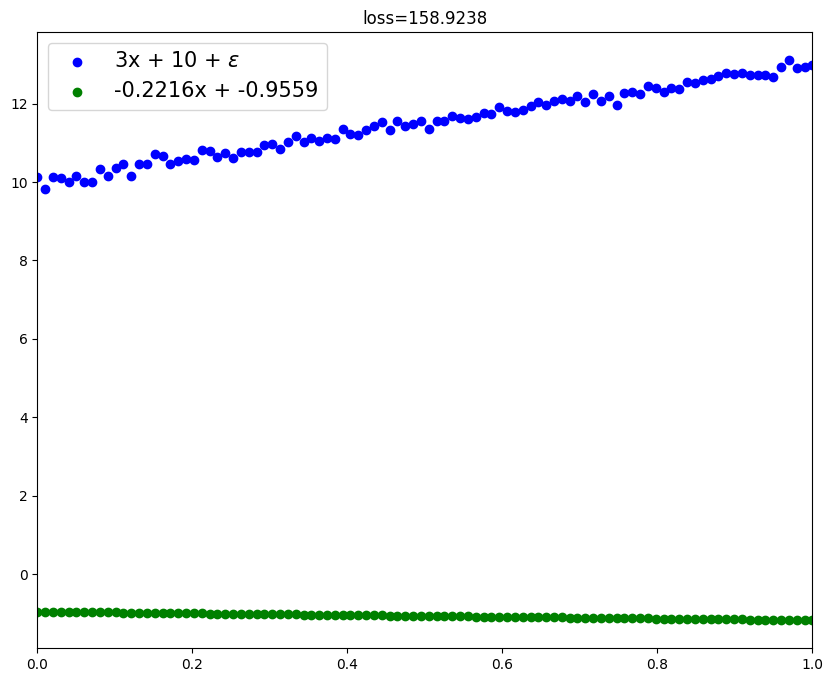

In [164]:
# 視覺化資料
w_pred = model.fc.weight.data[0][0]
b_pred = model.fc.bias.data[0]
plt.figure(figsize=(10, 8))
plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\\epsilon$')
plt.scatter(x_in, y_pred, c = 'g', label='%1.4fx + %1.4f' % (w_pred, b_pred))
plt.title(f'loss={mse:.4f}')
plt.axis(xmin=0, xmax=1)
plt.legend(fontsize = 15)
plt.show()

### 各部分功能
1. 提取模型參數
- w_pred = model.fc.weight.data[0][0] - 獲取訓練後的權重（斜率）
- b_pred = model.fc.bias.data[0] - 獲取訓練後的偏置（截距）

2. 建立圖表
- plt.figure(figsize=(10, 8)) - 創建 10×8 英吋的圖表

3. 繪製散點圖
- 藍色點：plt.scatter(x_in, y_noise, c='b')
  * 顯示原始帶雜訊的資料
  * 標籤：'3x + 10 + $\\epsilon$'（真實函數）
- 綠色點：plt.scatter(x_in, y_pred, c='g')
  * 顯示模型預測結果
  * 標籤：動態顯示學習到的參數 'w_pred×x + b_pred'
  * 
4. 圖表裝飾
- plt.title(f'loss={mse:.4f}') - 顯示MSE 損失值
- plt.axis(xmin=0, xmax=1) - 設定 x 軸範圍為 0-1
- plt.legend(fontsize=15) - 顯示圖例，字體大小 15
視覺化目的
這個圖表幫助您：

✅ 評估模型效果：綠色預測點與藍色真實點越接近 = 模型訓練越成功

✅ 比較參數學習：觀察學習到的 w_pred, b_pred 與目標值 w=3, b=10 的差異

✅ 直觀理解損失：通過視覺化直接看出模型的擬合程度

預期結果
- 訓練前：綠色點散亂，與藍色點差異很大
- 訓練後：綠色點應該與藍色點重疊，形成近似 y = 3x + 10 的直線
這是深度學習中非常重要的可視化驗證步驟！

## 3. 模型的設定

pytorch 在訓練模型前，需要設定損失函數 (loss function) 、優化器 (optimizer)。

迴歸任務參數：
* `loss`: 迴歸問題的損失函數常常使用 `mean_squared_error`, `mean_absolute_error`，更多其他的損失函數可以參考 https://pytorch.org/docs/stable/nn.html#loss-functions 。
* `optimizer`: 優化器決定參數更新的方式，目前最常使用的優化器為 `SGD, RMSprop, Adam`，更多其他的優化器可以參考 https://pytorch.org/docs/stable/optim.html#algorithms 。

為什麼需要這兩個組件？
- 損失函數：提供一個量化的方式來評估模型表現，告訴我們「預測有多錯」
- 優化器：根據損失函數的梯度來更新模型參數，實現「如何改進模型」

這兩個組件是 PyTorch 訓練循環中不可或缺的核心元素！

In [165]:
# 設定 loss function
criterion = nn.MSELoss()
# 設定 learning rate
lr = 1e-2
# 設定訓練的 epoch 數量
epochs = 100
# 設定優化器，這裡以sgd為例
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## 4. 模型的訓練

在 pytorch 的模型訓練中，我們需要有幾個步驟來完成訓練:
1. 使用迴圈來決定要訓練幾個 epoch
2. 一次訓練一個 batch，看完所有的訓練資料後就結束一個 epoch
3. 先進行模型 feed forward 的動作
4. feed forward 後會有模型預測出來的結果，將結果去對應到真實標籤，然後計算出 loss
5. 有 loss 的話就能回推 gradients
6. 使用 gradients 的結果來更新 weight，這時候就是優化器來決定更新方式
7. 重複以上步驟

In [166]:
# 訓練過程
loss_history = []

# 第 1 步驟
for epoch in range(epochs): #range(100) 會產生 0, 1, 2, 3, ..., 99。共有 100 個數字
    # 訓練階段
    model.train()
    running_loss = 0.0  # 訓練時的loss

    # 第 2 步驟
    for times, data_train in enumerate(Train_list):  # data_train會包括訓練的資料以及訓練的標籤
        # batch data input
        inputs, labels = data_train
        inputs, labels = torch.from_numpy(inputs).to(device), torch.from_numpy(labels).to(device)

        # 第 3 步驟
        optimizer.zero_grad()  # Zero the parameter gradients
        output_train = model(inputs)  # model Feedforward

        # 第 4 步驟
        loss = criterion(output_train, labels)  # Feed forward loss result

        # 第 5 步驟
        loss.backward()  # backward update

        # 第 6 步驟
        optimizer.step()  # optimize

        # 將每一筆資料的 loss 都加起來，假設有 100 筆資料就會有 100 個 loss 的結果
        running_loss += loss.item()  # Compute loss

        # 當一個 epoch 結束後，顯示結果
        if times+1 == len(Train_list):
            print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1,
                                                 epochs,times+1,
                                                 len(Train_list),
                                                 running_loss/len(Train_list),))

            loss_history.append(running_loss/len(Train_list))
            running_loss = 0.0

print('Finished Training')

[1/100, 100/100] loss: 8.787
[2/100, 100/100] loss: 0.591
[3/100, 100/100] loss: 0.258
[4/100, 100/100] loss: 0.125
[5/100, 100/100] loss: 0.064
[6/100, 100/100] loss: 0.036
[2/100, 100/100] loss: 0.591
[3/100, 100/100] loss: 0.258
[4/100, 100/100] loss: 0.125
[5/100, 100/100] loss: 0.064
[6/100, 100/100] loss: 0.036
[7/100, 100/100] loss: 0.023
[8/100, 100/100] loss: 0.017
[7/100, 100/100] loss: 0.023
[8/100, 100/100] loss: 0.017
[9/100, 100/100] loss: 0.014
[10/100, 100/100] loss: 0.013
[11/100, 100/100] loss: 0.012
[12/100, 100/100] loss: 0.012
[9/100, 100/100] loss: 0.014
[10/100, 100/100] loss: 0.013
[11/100, 100/100] loss: 0.012
[12/100, 100/100] loss: 0.012
[13/100, 100/100] loss: 0.012
[14/100, 100/100] loss: 0.012
[13/100, 100/100] loss: 0.012
[14/100, 100/100] loss: 0.012
[15/100, 100/100] loss: 0.012
[16/100, 100/100] loss: 0.012
[17/100, 100/100] loss: 0.012
[18/100, 100/100] loss: 0.012
[19/100, 100/100] loss: 0.012
[15/100, 100/100] loss: 0.012
[16/100, 100/100] loss: 0.0

## 5. 訓練完的預測表現

可以使用一些 `sklearn.metrics` 的評估指標，評估 `model(x)` 的結果與真實答案的差距。

In [167]:
batch_x_in = np.reshape(x_in, (-1,1))
batch_x_in = torch.from_numpy(batch_x_in).to(device)

y_pred = model(batch_x_in)
y_pred = y_pred.cpu().data.numpy()
y_pred = np.squeeze(y_pred)
mse = mean_squared_error(y_pred=y_pred, y_true=y_noise)
print('MSE: %.4f' % mse)

MSE: 0.0101


### 查看訓練參數

使用 `.weights` 以及 `.bias` 可以拿取模型所有的參數

In [168]:
print('w_true:', 3, '\nb_true:', 10)
print('-'*10)
print('w_pred:', model.fc.weight.data, '\nb_pred:', model.fc.bias.data)

w_true: 3 
b_true: 10
----------
w_pred: tensor([[3.0207]]) 
b_pred: tensor([10.0083])


### 視覺化結果

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\TEMP\ipykernel_20668\1358309683.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\epsilon$')


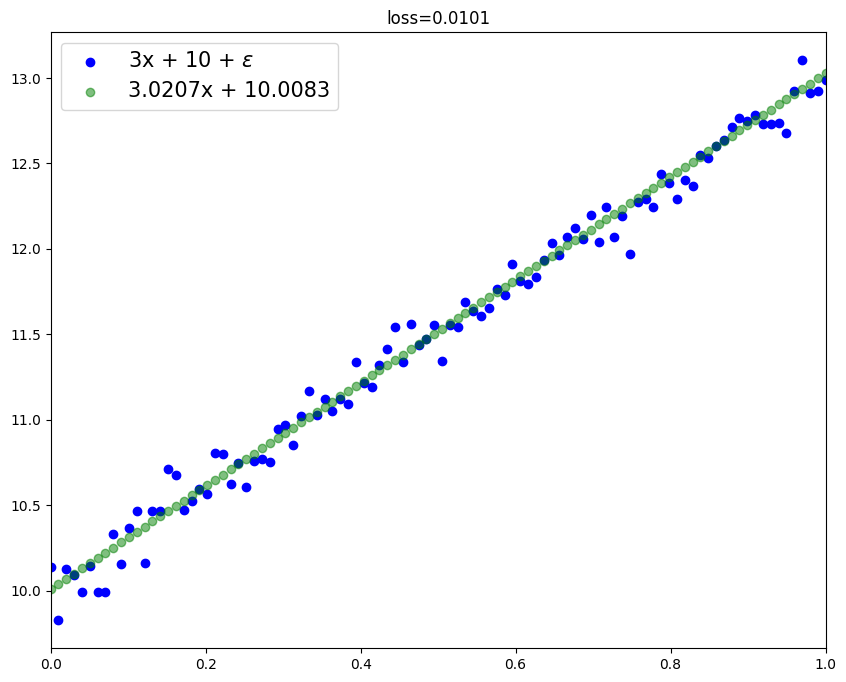

In [169]:
# 視覺化資料
# 重新提取訓練後的參數
w_pred = model.fc.weight.data[0][0]
b_pred = model.fc.bias.data[0]

plt.figure(figsize=(10, 8))
plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\epsilon$')
plt.scatter(x_in, y_pred, c = 'g', label='%1.4fx + %1.4f' % (w_pred, b_pred), alpha=0.5)
plt.title(f'loss={mse:.4f}')
plt.axis(xmin=0, xmax=1)
plt.legend(fontsize = 15)
plt.show()

# 三、 Linear Polynomial (二元一次多項式)，使用模型來進行一個訓練的流程

$$
f(x_1,x_2)=7x_1+3x_2+10
$$

## 1. 準備資料集

In [170]:
# 準備資料
x1 = np.float32(np.linspace(0, 1, 100))
x2 = np.float32(np.linspace(0, 1, 100))

np.random.shuffle(x2)

x_in = np.stack([x1, x2], axis=1)

y_true = 7 * x_in[:,0] + 3 * x_in[:,1] + 10

noise = np.float32(np.random.normal(0, 0.1, size=len(x1)))
y_noise = y_true + noise

In [171]:
print('x_in_shape:', x_in.shape)
print('y_true_shape:', y_true.shape)
print('y_noise_shape:', y_noise.shape)

x_in_shape: (100, 2)
y_true_shape: (100,)
y_noise_shape: (100,)


In [172]:
# 包成可供模型訓練的資料型態
Train_list = []

for i in range(len(x_in)):
    Train_list.append([np.array(x_in[i]), np.array([y_noise[i]])])

In [173]:
Train_list[0]

[array([0.        , 0.97979796], dtype=float32),
 array([13.094294], dtype=float32)]

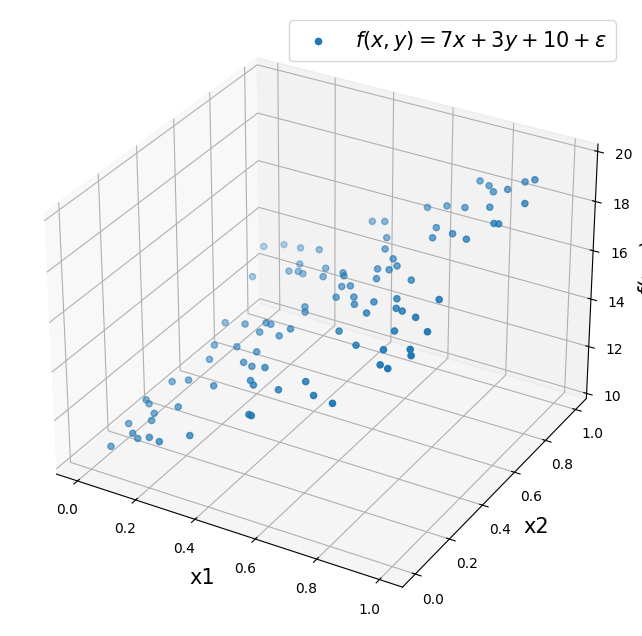

In [174]:
# 視覺化資料
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter(x_in[:,0], x_in[:,1], y_noise, label='$f(x,y)=7x+3y+10+\\epsilon$')
plt.legend(fontsize=15)
ax.set_xlabel('x1', fontsize=15)
ax.set_ylabel('x2', fontsize=15)
ax.set_zlabel('f(x,y)', fontsize=15)
plt.show()

## 2. 建立模型

In [175]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc = nn.Linear(in_features = 2, out_features = 1, bias = True)

    def forward(self, x):
        output = self.fc(x)
        return output

model = DNN().to(device)
model

DNN(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

## 還沒訓練時的預測表現

### 查看模型參數

使用 `.weights` 以及 `.bias` 可以拿取模型所有的參數

In [176]:
w1_pred = model.fc.weight[0][0].data
w2_pred = model.fc.weight[0][1].data
b_pred = model.fc.bias[0].data

print('w1_true:', 7, '\nw2_true:', 3,'\nb_true:', 10)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nb_pred:', b_pred)

w1_true: 7 
w2_true: 3 
b_true: 10
----------
w1_pred: tensor(-0.3746) 
w2_pred: tensor(0.2437) 
b_pred: tensor(0.6005)


In [177]:
batch_x_in = np.reshape(x_in, (-1,2))
batch_x_in = torch.from_numpy(batch_x_in).to(device)

y_pred = model(batch_x_in)
y_pred = y_pred.cpu().data.numpy()
y_pred = np.squeeze(y_pred)
mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
print(mse)

214.8584442138672


### 視覺化結果

因為還沒開始訓練，所以預測表現不好。

*權重的初始化為 `glorot_uniform`，所以預測值都會接近 1*

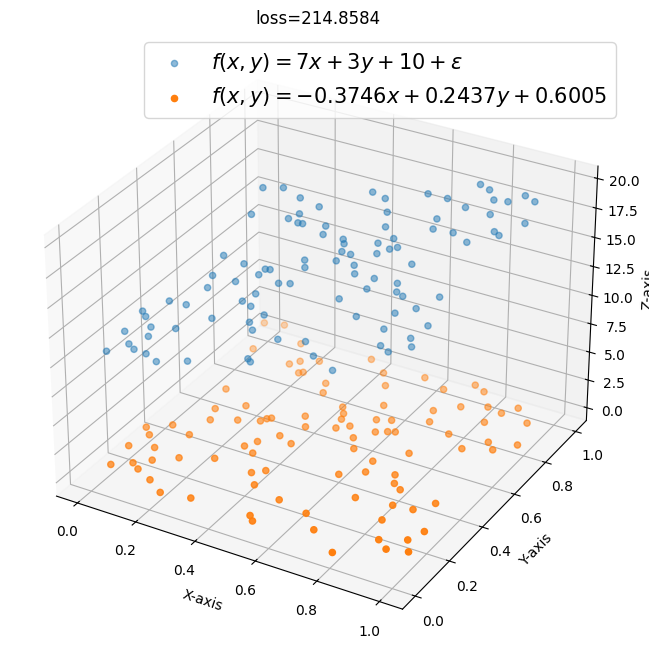

In [178]:
# 視覺化資料
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter(x_in[:,0], x_in[:,1], y_noise, label='$f(x,y)=7x+3y+10+\\epsilon$', alpha = 0.5)
ax.scatter(x_in[:,0], x_in[:,1], y_pred, label='$f(x,y)=%1.4fx+%1.4fy+%1.4f$' % (w1_pred, w2_pred, b_pred))
plt.title(f'loss={mse:.4f}')
plt.legend(fontsize=15)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

## 3. 模型設定

In [179]:
# 設定loss function
criterion = nn.MSELoss()

# 設定learning rate
lr = 1e-4

# 設定訓練的epoch數量
epochs = 100

# 設定優化器，這裡以sgd為例
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## 4. 模型訓練

In [180]:
# 訓練過程
loss_history = []

# 第 1 步驟
for epoch in range(epochs):
    # 訓練階段
    model.train()
    running_loss = 0.0  # 訓練時的loss

    # 第 2 步驟
    for times, data_train in enumerate(Train_list):  # data_train會包括訓練的資料以及訓練的標籤
        # batch data input
        inputs, labels = data_train
        inputs, labels = torch.from_numpy(inputs).to(device), torch.from_numpy(labels).to(device)

        # 第 3 步驟
        optimizer.zero_grad()  # Zero the parameter gradients
        output_train = model(inputs)  # model Feedforward

        # 第 4 步驟
        loss = criterion(output_train, labels)  # Feed forward loss result

        # 第 5 步驟
        loss.backward()  # backward update

        # 第 6 步驟
        optimizer.step()  # optimize

        # 將每一筆資料的 loss 都加起來，假設有 100 筆資料就會有 100 個 loss 的結果
        running_loss += loss.item()  # Compute loss

        # 當一個 epoch 結束後，顯示結果
        if times+1 == len(Train_list):
            print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1,
                                                 epochs,times+1,
                                                 len(Train_list),
                                                 running_loss/len(Train_list),))

            loss_history.append(running_loss/len(Train_list))
            running_loss = 0.0

print('Finished Training')

[1/100, 100/100] loss: 169.293
[2/100, 100/100] loss: 90.549
[3/100, 100/100] loss: 48.248
[4/100, 100/100] loss: 25.840
[5/100, 100/100] loss: 13.978
[6/100, 100/100] loss: 7.701
[7/100, 100/100] loss: 4.382
[8/100, 100/100] loss: 2.626
[9/100, 100/100] loss: 1.695
[10/100, 100/100] loss: 1.200
[11/100, 100/100] loss: 0.934
[12/100, 100/100] loss: 0.788
[7/100, 100/100] loss: 4.382
[8/100, 100/100] loss: 2.626
[9/100, 100/100] loss: 1.695
[10/100, 100/100] loss: 1.200
[11/100, 100/100] loss: 0.934
[12/100, 100/100] loss: 0.788
[13/100, 100/100] loss: 0.705
[14/100, 100/100] loss: 0.654
[15/100, 100/100] loss: 0.620
[16/100, 100/100] loss: 0.595
[17/100, 100/100] loss: 0.575
[18/100, 100/100] loss: 0.557
[19/100, 100/100] loss: 0.540
[13/100, 100/100] loss: 0.705
[14/100, 100/100] loss: 0.654
[15/100, 100/100] loss: 0.620
[16/100, 100/100] loss: 0.595
[17/100, 100/100] loss: 0.575
[18/100, 100/100] loss: 0.557
[19/100, 100/100] loss: 0.540
[20/100, 100/100] loss: 0.524
[21/100, 100/100

## 5. 訓練完的預測表現

In [181]:
batch_x_in = np.reshape(x_in, (-1,2))
batch_x_in = torch.from_numpy(batch_x_in).to(device)

y_pred = model(batch_x_in)
y_pred = y_pred.cpu().data.numpy()
y_pred = np.squeeze(y_pred)
mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
print('MSE: %.4f' % mse)

MSE: 0.0374


### 查看訓練參數

使用 `.weights` 以及 `.bias` 可以拿取模型所有的參數

In [182]:
w1_pred = model.fc.weight[0][0].data
w2_pred = model.fc.weight[0][1].data
b_pred = model.fc.bias[0].data

print('w1_true:', 7, '\nw2_true:', 3,'\nb_true:', 10)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nb_pred:', b_pred)

w1_true: 7 
w2_true: 3 
b_true: 10
----------
w1_pred: tensor(6.5013) 
w2_pred: tensor(3.4853) 
b_pred: tensor(10.0274)


### 視覺化結果


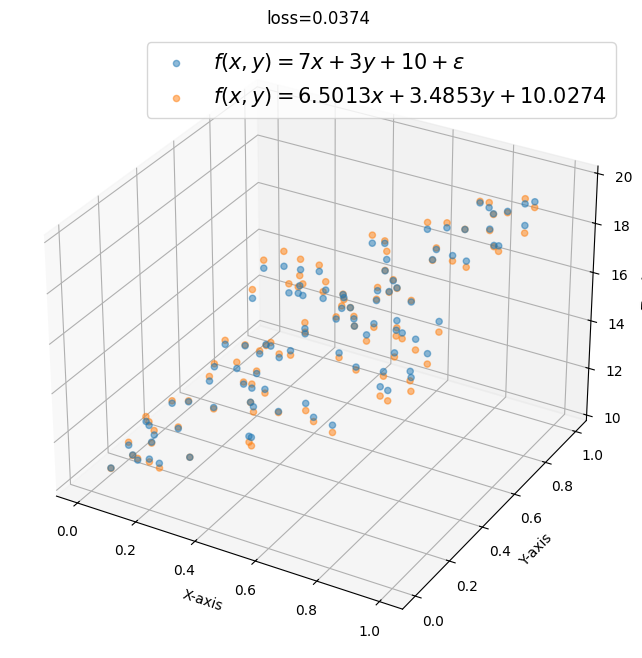

In [183]:
# 視覺化資料
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.scatter(x_in[:,0], x_in[:,1], y_noise, label='$f(x,y)=7x+3y+10+\\epsilon$', alpha = 0.5)
ax.scatter(x_in[:,0], x_in[:,1], y_pred, label='$f(x,y)=%1.4fx+%1.4fy+%1.4f$' % (w1_pred, w2_pred, b_pred), alpha=0.5)
plt.title(f'loss={mse:.4f}')
plt.legend(fontsize=15)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

# 三、 動手試試看 (三元一次多項式)，使用模型來進行一個訓練的流程

通常資料和神經網路內部訓練的維度是非常高的，所以通常不可能像上面兩個例子畫得出來，只能從評分指標 (MSE, R2, Precision, Recall) 去觀察模型表現。

請使用以下的資料點 $x$ 及 $y$ 去擬合函數：

$$
f(x_1,x_2,x_3) = 10x_1+8x_2+6x_3+4
$$

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡

## 1. 準備資料集

In [185]:
# 準備資料, 共四個維度 f(x1,x2,x3), x1, x2, x3
x1 = np.float32(np.linspace(0, 1, 500))
x2 = np.float32(np.linspace(0, 1, 500))
x3 = np.float32(np.linspace(0, 1, 500))

np.random.shuffle(x2)
np.random.shuffle(x3)

x_in = np.stack([x1, x2, x3], axis=1)

y_true = 10 * x_in[:,0] + 8 * x_in[:,1] + 6 * x_in[:,2] + 4

noise = np.float32(np.random.normal(0, 0.1, size=len(x1)))
y_noise = y_true + noise

In [186]:
print('x_in_shape:', x_in.shape)
print('y_true_shape:', y_true.shape)
print('y_noise_shape:', y_noise.shape)

x_in_shape: (500, 3)
y_true_shape: (500,)
y_noise_shape: (500,)


In [187]:
# 包成可供模型訓練的資料型態
Train_list = []

for i in range(len(x_in)):
    Train_list.append([np.array(x_in[i]), np.array([y_noise[i]])])
print(Train_list[0])

[array([0.        , 0.26452905, 0.9498998 ], dtype=float32), array([11.795069], dtype=float32)]


## 2. 建立模型

接下來使用 model subclassing 的方式建立模型。

In [188]:
import torch.nn as nn

class DNN_test(nn.Module):
    def __init__(self):
        super(DNN_test, self).__init__()
        self.fc = nn.Linear(in_features=3, out_features=1, bias=True)

    def forward(self, x):
        output = self.fc(x)
        return output

### 查看訓練參數

使用 `.weight` 以及 `.bias` 可以拿取模型所有的參數

In [189]:
# 建立模型
model = DNN_test().to(device)

# 正確存取參數
w1_pred = model.fc.weight[0][0].data
w2_pred = model.fc.weight[0][1].data
w3_pred = model.fc.weight[0][2].data
b_pred = model.fc.bias[0].data


print('w1_true:', 10, '\nw2_true:', 8, '\nw3_true:', 6, '\nb_true:', 4)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nw3_pred:', w3_pred, '\nb_pred:', b_pred)

w1_true: 10 
w2_true: 8 
w3_true: 6 
b_true: 4
----------
w1_pred: tensor(0.0398) 
w2_pred: tensor(0.0634) 
w3_pred: tensor(0.2035) 
b_pred: tensor(-0.3046)


## 3. 模型設定

* Opimitizer 請使用 `SGD`, `learning_rate` 請設定為 `1e-2`
* Loss 請使用 `mean_squared_error`
* epochs 大小請設定 `300`

In [190]:
# 設定損失函數 - 使用 mean_squared_error (MSE)
criterion = nn.MSELoss()

# 設定學習率 - 1e-2 = 0.01
lr = 1e-2

# 設定訓練週期數 - 300 個 epochs
epochs = 300

# 設定優化器 - 使用 SGD
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## 4. 模型的訓練

在 pytorch 的模型訓練中，我們需要有幾個步驟來完成訓練:
1. 使用迴圈來決定要訓練幾個 epoch
2. 一次訓練一個 batch，看完所有的訓練資料後就結束一個 epoch
3. 先進行模型 feed forward 的動作
4. feed forward 後會有模型預測出來的結果，將結果去對應到真實標籤，然後計算出 loss
5. 有 loss 的話就能回推 gradients
6. 使用 gradients 的結果來更新 weight，這時候就是優化器來決定更新方式
7. 重複以上步驟

In [191]:
# 訓練過程
loss_history = []

# 第 1 步驟：Epoch 迴圈
for epoch in range(epochs):
    model.train()  # 設定為訓練模式
    running_loss = 0.0
    
    # 第 2 步驟：逐批次處理資料
    for times, data_train in enumerate(Train_list):
        inputs, labels = data_train
        inputs, labels = torch.from_numpy(inputs).to(device), torch.from_numpy(labels).to(device)
        
        # 第 3 步驟：前向傳播
        optimizer.zero_grad()  # 清零梯度
        output_train = model(inputs)  # 模型預測
        
        # 第 4 步驟：計算損失
        loss = criterion(output_train, labels)
        
        # 第 5 步驟：反向傳播計算梯度
        loss.backward()
        
        # 第 6 步驟：參數更新
        optimizer.step()
        
        # 記錄損失
        running_loss += loss.item()
    
    # 第 7 步驟：重複直到訓練完成
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(Train_list):.4f}')

Epoch [1/300], Loss: 1.9692
Epoch [2/300], Loss: 0.8015
Epoch [3/300], Loss: 0.4285
Epoch [4/300], Loss: 0.2305
Epoch [3/300], Loss: 0.4285
Epoch [4/300], Loss: 0.2305
Epoch [5/300], Loss: 0.1258
Epoch [6/300], Loss: 0.0707
Epoch [5/300], Loss: 0.1258
Epoch [6/300], Loss: 0.0707
Epoch [7/300], Loss: 0.0419
Epoch [8/300], Loss: 0.0271
Epoch [7/300], Loss: 0.0419
Epoch [8/300], Loss: 0.0271
Epoch [9/300], Loss: 0.0195
Epoch [10/300], Loss: 0.0158
Epoch [9/300], Loss: 0.0195
Epoch [10/300], Loss: 0.0158
Epoch [11/300], Loss: 0.0140
Epoch [12/300], Loss: 0.0132
Epoch [11/300], Loss: 0.0140
Epoch [12/300], Loss: 0.0132
Epoch [13/300], Loss: 0.0129
Epoch [14/300], Loss: 0.0129
Epoch [13/300], Loss: 0.0129
Epoch [14/300], Loss: 0.0129
Epoch [15/300], Loss: 0.0129
Epoch [16/300], Loss: 0.0130
Epoch [15/300], Loss: 0.0129
Epoch [16/300], Loss: 0.0130
Epoch [17/300], Loss: 0.0130
Epoch [18/300], Loss: 0.0131
Epoch [17/300], Loss: 0.0130
Epoch [18/300], Loss: 0.0131
Epoch [19/300], Loss: 0.0131
E

## 5. 訓練完的預測表現

請使用 `mean_squared_error` 評估模型表現。

In [192]:
from sklearn.metrics import mean_squared_error

# 準備預測資料 - 將輸入資料轉換為適合模型的格式
batch_x_in = np.reshape(x_in, (-1, 3))  # 三個特徵維度
batch_x_in = torch.from_numpy(batch_x_in).to(device)

# 模型預測
y_pred = model(batch_x_in)

# 將預測結果轉回 numpy 格式
y_pred = y_pred.cpu().data.numpy()
y_pred = np.squeeze(y_pred)

# 計算 MSE
mse = mean_squared_error(y_pred=y_pred, y_true=y_noise)
print('MSE: %.4f' % mse)

MSE: 0.0187


### 查看訓練參數

使用 `.weights` 以及 `.bias` 可以拿取模型所有的參數

In [193]:
# 提取訓練後的參數
w1_pred = model.fc.weight[0][0].data
w2_pred = model.fc.weight[0][1].data
w3_pred = model.fc.weight[0][2].data
b_pred = model.fc.bias[0].data

print('w1_true:', 10, '\nw2_true:', 8, '\nw3_true:', 6, '\nb_true:', 4)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nw3_pred:', w3_pred, '\nb_pred:', b_pred)

w1_true: 10 
w2_true: 8 
w3_true: 6 
b_true: 4
----------
w1_pred: tensor(10.1899) 
w2_pred: tensor(8.0232) 
w3_pred: tensor(6.0051) 
b_pred: tensor(3.8173)
